In [1]:
# BertConfig: https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/bert#transformers.BertConfig
#             https://medium.com/analytics-vidhya/choosing-the-right-parameters-for-pre-training-bert-using-tpu-4584a598ca50
# BERT -> bert-base-uncased
# ClinicalBERT -> emilyalsentzer/Bio_ClinicalBERT -> trovare figura descrittiva del modello
bert_model = 'emilyalsentzer/Bio_ClinicalBERT'
batch_size = 16
padding_max_length = 512 # max value for gelu_new and for batch_size > 16 because of RAM limitation of Colab free

# https://www.mdpi.com/2227-7390/10/3/337/htm, https://arxiv.org/abs/1606.08415, https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
activation_function = 'gelu' 

freeze_layer_count = 8
path = 'NEW/KFold'

# See: https://link.springer.com/chapter/10.1007/978-3-030-76508-8_11
attention_dropout_value = 0.5
hidden_dropout_value = 0.1

# Test data is 20% of whole dataset
val_ratio = 0.2

# Remamining dataset is splitted 80-20 for training-validation
# (Percentage to the whole dataset for training/validation/testing are: 64-16-20)
val_ratio_tv = 0.2

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 7

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
learning_rate = 2e-5

In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch, gc
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Subset
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

import os
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline  

/home/utentec20/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-19 10:30:24.059193: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-19 10:30:24.094482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 10:30:24.661880: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Ten

In [5]:
url = "HitBert Labels.CSV"
data = pd.read_csv(url, sep=";")

In [6]:
text = data.TEXT.values
labels = data.LABEL.values

In [7]:
tokenizer = AutoTokenizer.from_pretrained(bert_model, do_lower_case = True)

In [8]:
def preprocessing(input_text, tokenizer):
  return tokenizer.encode_plus(
      input_text,
      add_special_tokens = True,
      max_length = padding_max_length,
      truncation = True,
      padding='max_length',
      return_attention_mask = True,
      return_tensors = 'pt'
  )

In [9]:
token_id = []
attention_masks = []

for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids'])
    attention_masks.append(encoding_dict['attention_mask'])


In [10]:
# Convert the lists into tensors.

token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [11]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    random_state = 42,
    shuffle = True,
    stratify = labels)

test_set = TensorDataset(token_id[test_idx],
                         attention_masks[test_idx],
                         labels[test_idx])

testing_dataloader = DataLoader(
            test_set,
            sampler = SequentialSampler(test_set),
            batch_size = batch_size
)

In [12]:
train_labels = labels[train_idx]
train_tokens = token_id[train_idx]
train_masks = attention_masks[train_idx]

training_dataset = TensorDataset(train_tokens, train_masks, train_labels)

In [13]:
# Set the seed value all over the place to make this reproducible.
seed_val = 1000
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [14]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained(
    bert_model,
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
    attention_probs_dropout_prob = attention_dropout_value,
    hidden_dropout_prob  = hidden_dropout_value,
    hidden_act = activation_function
)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# Run on GPU
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
# freezing layers for fine-tuning

for param in model.bert.embeddings.parameters():
    param.requires_grad = False

if freeze_layer_count != -1:
    for layer in model.bert.encoder.layer[:freeze_layer_count]:
        for param in layer.parameters():
            param.requires_grad = False

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Compute metrics on model 
def b_metrics(probs, y_true):
  y_pred = tf.math.argmax(probs, axis=1)
  b_accuracy = accuracy_score(y_true, y_pred)
  b_precision = precision_score(y_true, y_pred)
  b_recall = recall_score(y_true, y_pred)
  b_f1 = f1_score(y_true, y_pred)
  cm = confusion_matrix(y_true, y_pred)
  b_specificity = cm[0,0] / (cm[0,0] + cm[0,1])
  
  return b_accuracy, b_precision, b_recall, b_specificity, b_f1

In [19]:
n_fold = 10

In [20]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits = n_fold, random_state = seed_val, shuffle = True)

In [21]:
#helper function to get train and val data loaders for each fold
 
def get_data_loaders(dataset,train_indexes,val_indexes):
    train_tensor = Subset(dataset,train_indexes)
    val_tensor = Subset(dataset,val_indexes)
    train_dataloader = DataLoader(
            train_tensor, 
            sampler = RandomSampler(train_tensor), 
            batch_size = batch_size
        )

    val_dataloader = DataLoader(
            val_tensor, 
            sampler = SequentialSampler(val_tensor), 
            batch_size = batch_size 
        )
    return train_dataloader,val_dataloader

In [22]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', 
                                     classes = np.unique(train_labels.numpy()), 
                                     y = train_labels.numpy())
weights = torch.tensor(class_weights)
weights = weights.float()

# Compute Cross Entropy Loss on model's validation
cross_entropy = nn.CrossEntropyLoss(weight=weights)

In [23]:
# Plot training performance and train-val loss comparison

def PlotTrainingPerformance(train_loss, val_loss, train_loss_set):
  e = range(1, epochs + 1)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_figheight(5)
  fig.set_figwidth(15)
  ax1.plot(e, train_loss, 'b', label='Train loss')
  ax1.plot(e, val_loss, 'r', label='Validation loss')
  ax1.set(xlabel='Epochs', ylabel='Loss', title = 'Comparing training and validation loss', xticks = e)
  ax1.legend()
  ax2.set(xlabel="Batch", ylabel="Loss", title="Training loss")
  ax2.plot(train_loss_set)

In [34]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
### Training and Validation

training_stats = []
current_fold = 0

for train_id, val_id in kf.split(np.arange(len(train_labels)), train_labels):
  current_fold += 1

  f_model = model
  optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = learning_rate,
                              eps = 1e-08
                              )
  

  # Train and validation sets
  train_dataloader, validation_dataloader = get_data_loaders(training_dataset, train_id, val_id)

  #Array for collection losses for plotting
  train_loss_set = []
  train_loss = []
  val_loss = []
  f_accuracy = []
  f_precision = []
  f_recall = []
  f_specificity = []
  f_f1 = []
  print('================= Fold: {:}/{:} ================='.format(current_fold,n_fold))

  for ee in range(0, epochs):
      
      # ========== Training ==========
      
      # Set model to training mode
      f_model.train()
      
      # Tracking variables
      tr_loss = 0
      nb_tr_examples, nb_tr_steps = 0, 0

      for step, batch in enumerate(train_dataloader):
          batch = tuple(t.to(device) for t in batch)
          b_input_ids, b_input_mask, b_labels = batch
          optimizer.zero_grad()
          # Forward pass
          train_output = f_model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask,
                              labels = b_labels)
          train_loss_set.append(train_output.loss.item())    
          # Backward pass
          train_output.loss.backward()
          optimizer.step()
          # Update tracking variables
          tr_loss += train_output.loss.item()
          nb_tr_examples += b_input_ids.size(0)
          nb_tr_steps += 1

      # ========== Validation ==========

      # Set model to evaluation mode
      f_model.eval()

      # Tracking variables 
      all_logits = []
      true_labels = []
      total_loss = 0

      for batch in validation_dataloader:
          batch = tuple(t.to(device) for t in batch)
          b_input_ids, b_input_mask, b_labels = batch
          with torch.no_grad():
            # Forward pass
            eval_output = f_model(b_input_ids, 
                                token_type_ids = None, 
                                attention_mask = b_input_mask)
          logits = eval_output.logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          all_logits.append(logits)
          true_labels.append(label_ids)
          loss = cross_entropy(torch.from_numpy(logits), torch.from_numpy(label_ids))
          total_loss += loss.item()

      # Concatenate logits and true_labels from each batch
      all_logits = np.concatenate(all_logits, axis=0)
      true_labels = np.concatenate(true_labels, axis=0)

      # Apply softmax to calculate probabilities
      tlogits = torch.from_numpy(all_logits)
      probs = F.softmax(tlogits, dim=1).cpu().numpy()

      # Compute metrics
      b_accuracy, b_precision, b_recall, b_specificity, b_f1 = b_metrics(probs, true_labels)
      
      train_loss.append(tr_loss / nb_tr_steps)
      val_loss.append(total_loss / len(validation_dataloader))

      f_accuracy.append(b_accuracy)
      f_precision.append(b_precision)
      f_recall.append(b_recall)
      f_f1.append(b_f1)
      f_specificity.append(b_specificity)

  # Printing results
  print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
  print('\t - Validation loss: {:.4f}'.format(total_loss / len(validation_dataloader)))
  print('\t - Validation Accuracy: {:.4f}'.format(b_accuracy))
  print('\t - Validation Precision: {:.4f}'.format(b_precision))
  print('\t - Validation Recall: {:.4f}'.format(b_recall))
  print('\t - Validation Specificity: {:.4f}'.format(b_specificity))
  print('\t - Validation F1 Score: {:.4f}\n'.format(b_f1))
  
  training_stats.append({
    'fold': current_fold,
    'epochs': epochs,
    'activation_function': activation_function,
    'batch_size': batch_size,
    'padding_max_length': padding_max_length,
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'train_loss_set': train_loss_set,
    'val_loss': val_loss,
    'accuracy': f_accuracy,
    'precision': f_precision,
    'recall': f_recall,
    'specificity': f_specificity,
    'f1': f_f1,
    'model_state_dict': model.state_dict()
  })
  torch.save(training_stats[-1], path + '/HitBert_kfold_' + str(current_fold) + '_{0:.4}'.format(b_accuracy) + '.pt')

  del f_model
  del optimizer
  del batch
  del step
  del train_output
  del eval_output
  gc.collect()
  torch.cuda.empty_cache()

In [ ]:
files = []
for f in os.listdir(path):
  if f.endswith('pt'):
    files.append(f)

for f in files:
  cp = torch.load(path + '/' + f)
  print('FOLD n: ' + str(cp['fold']))
  PlotTrainingPerformance(cp['train_loss'], cp['val_loss'], cp['train_loss_set'])

In [ ]:
training_stats = []
for f in files:
  training_stats.append({
    'fold': cp['fold'],
    'epochs': cp['epochs'],
    'activation_function': cp['activation_function'],
    'batch_size': cp['batch_size'],
    'padding_max_length': cp['padding_max_length'],
    'train_loss': cp['train_loss'][-1],
    'val_loss': cp['val_loss'][-1],
    'train_loss_set': cp['train_loss_set'][-1],
    'accuracy': cp['accuracy'][-1],
    'precision': cp['precision'][-1],
    'recall': cp['recall'][-1],
    'specificity': cp['specificity'][-1],
    'f1': cp['f1'][-1]
  })

  del cp
  gc.collect()
  torch.cuda.empty_cache()

In [37]:
# Saving training metrics to CSV for each fold
pd.set_option('display.precision', 4)
dt_stats = pd.DataFrame(data=training_stats)
dt_stats = dt_stats.set_index('fold')
dt_stats
dt_stats.to_csv(path + '/HitBert_' + str(n_fold) + 'kfold_training_stats.csv')

In [59]:
from tqdm import tqdm

all_folds_preds = []
all_folds_metrics = []

k = 0
files = []
for f in os.listdir(path):
  if f.endswith('pt'):
    files.append(f)

for f in tqdm(files, total = n_fold, desc = "Fold"):
  cp = torch.load(path + '/' + f)
  k += 1

  # ========== Testing ========== 

  f_model = model
  f_model.load_state_dict(cp['model_state_dict'])
  f_model.cuda()
  f_model.eval()

  all_logits = []
  true_labels = []

  # For each batch in our test set...
  for batch in testing_dataloader:
    # Load batch to GPU
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    # Compute logits
    with torch.no_grad():
      eval_output = f_model(b_input_ids,
                          token_type_ids = None, 
                          attention_mask = b_input_mask)
    logits = eval_output.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    all_logits.append(logits)
    true_labels.append(label_ids)

  # Concatenate logits and true_labels from each batch
  all_logits = np.concatenate(all_logits, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Apply softmax to calculate probabilities
  tlogits = torch.from_numpy(all_logits)
  probs = F.softmax(tlogits, dim=1).cpu().numpy()

  b_accuracy, b_precision, b_recall, b_specificity, b_f1 = b_metrics(probs, true_labels)
  print('\n\tTesting metrics fold n.' + str(k) + ':')
  print('\t - Accuracy: {:.4f}'.format(b_accuracy))
  print('\t - Precision: {:.4f}'.format(b_precision))
  print('\t - Recall: {:.4f}'.format(b_recall))
  print('\t - Specificity: {:.4f}'.format(b_specificity))
  print('\t - F1 Score: {:.4f}'.format(b_f1))

  # Matthews correlation coefficient (MCC)
  # A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. 
  # The statistic is also known as the phi coefficient. 
  b_matthews_corrcoef = matthews_corrcoef(true_labels, tf.math.argmax(probs, axis=1))
  print('\tClassification accuracy using BERT Fine Tuning (MCC): {0:.2%}\n'.format(b_matthews_corrcoef))

  all_folds_preds.append({
      'fold': cp['fold'],
      'probs': probs,
      'true_labels': true_labels
  })

  all_folds_metrics.append({
      'fold': cp['fold'],
      'accuracy': b_accuracy,
      'precision': b_precision,
      'recall': b_recall,
      'specificity': b_specificity,
      'f1': b_f1,
      'mcc': b_matthews_corrcoef
  })

  del cp
  del f_model
  del eval_output
  torch.cuda.empty_cache()

Fold:  10%|█         | 1/10 [00:05<00:49,  5.45s/it]


	Testing metrics fold n.1:
	 - Accuracy: 0.9933
	 - Precision: 0.9946
	 - Recall: 0.9919
	 - Specificity: 0.9946
	 - F1 Score: 0.9933
	Classification accuracy using BERT Fine Tuning (MCC): 98.65%



Fold:  20%|██        | 2/10 [00:10<00:43,  5.44s/it]


	Testing metrics fold n.2:
	 - Accuracy: 0.9919
	 - Precision: 0.9893
	 - Recall: 0.9946
	 - Specificity: 0.9892
	 - F1 Score: 0.9919
	Classification accuracy using BERT Fine Tuning (MCC): 98.38%



Fold:  30%|███       | 3/10 [00:16<00:38,  5.44s/it]


	Testing metrics fold n.3:
	 - Accuracy: 0.9919
	 - Precision: 0.9841
	 - Recall: 1.0000
	 - Specificity: 0.9838
	 - F1 Score: 0.9920
	Classification accuracy using BERT Fine Tuning (MCC): 98.39%



Fold:  40%|████      | 4/10 [00:21<00:32,  5.44s/it]


	Testing metrics fold n.4:
	 - Accuracy: 0.9946
	 - Precision: 0.9893
	 - Recall: 1.0000
	 - Specificity: 0.9892
	 - F1 Score: 0.9946
	Classification accuracy using BERT Fine Tuning (MCC): 98.93%



Fold:  50%|█████     | 5/10 [00:27<00:27,  5.45s/it]


	Testing metrics fold n.5:
	 - Accuracy: 0.9865
	 - Precision: 0.9972
	 - Recall: 0.9757
	 - Specificity: 0.9973
	 - F1 Score: 0.9864
	Classification accuracy using BERT Fine Tuning (MCC): 97.32%



Fold:  60%|██████    | 6/10 [00:32<00:21,  5.46s/it]


	Testing metrics fold n.6:
	 - Accuracy: 0.9730
	 - Precision: 0.9889
	 - Recall: 0.9569
	 - Specificity: 0.9892
	 - F1 Score: 0.9726
	Classification accuracy using BERT Fine Tuning (MCC): 94.65%



Fold:  70%|███████   | 7/10 [00:38<00:16,  5.46s/it]


	Testing metrics fold n.7:
	 - Accuracy: 0.9919
	 - Precision: 0.9973
	 - Recall: 0.9865
	 - Specificity: 0.9973
	 - F1 Score: 0.9919
	Classification accuracy using BERT Fine Tuning (MCC): 98.39%



Fold:  80%|████████  | 8/10 [00:43<00:10,  5.47s/it]


	Testing metrics fold n.8:
	 - Accuracy: 0.9933
	 - Precision: 0.9919
	 - Recall: 0.9946
	 - Specificity: 0.9919
	 - F1 Score: 0.9933
	Classification accuracy using BERT Fine Tuning (MCC): 98.65%



Fold:  90%|█████████ | 9/10 [00:49<00:05,  5.47s/it]


	Testing metrics fold n.9:
	 - Accuracy: 0.9933
	 - Precision: 0.9867
	 - Recall: 1.0000
	 - Specificity: 0.9865
	 - F1 Score: 0.9933
	Classification accuracy using BERT Fine Tuning (MCC): 98.66%



Fold: 100%|██████████| 10/10 [00:54<00:00,  5.46s/it]


	Testing metrics fold n.10:
	 - Accuracy: 0.9933
	 - Precision: 0.9919
	 - Recall: 0.9946
	 - Specificity: 0.9919
	 - F1 Score: 0.9933
	Classification accuracy using BERT Fine Tuning (MCC): 98.65%



In [62]:
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

# Plotting ROC Curve and Confusion Matrix
def ROC_CM(probs, y_true):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc =  roc_auc_score(y_true, preds)
    
    y_pred = tf.math.argmax(probs, axis=1)
    cm = tf.math.confusion_matrix(y_true, y_pred).numpy()
    con_mat_df = pd.DataFrame(cm)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    # Plot ROC AUC
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set(title='ROC curve', ylabel='True Positive Rate', xlabel='False Positive Rate', xlim=[0,1], ylim=[0,1])
    ax1.legend(loc = 'lower right')
    
    # Plot Confusion Matrix  
    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar = False, ax=ax2)
    ax2.set(ylabel='True label', xlabel='Predicted label')

In [66]:
better_fold_index = 3 #fold n4

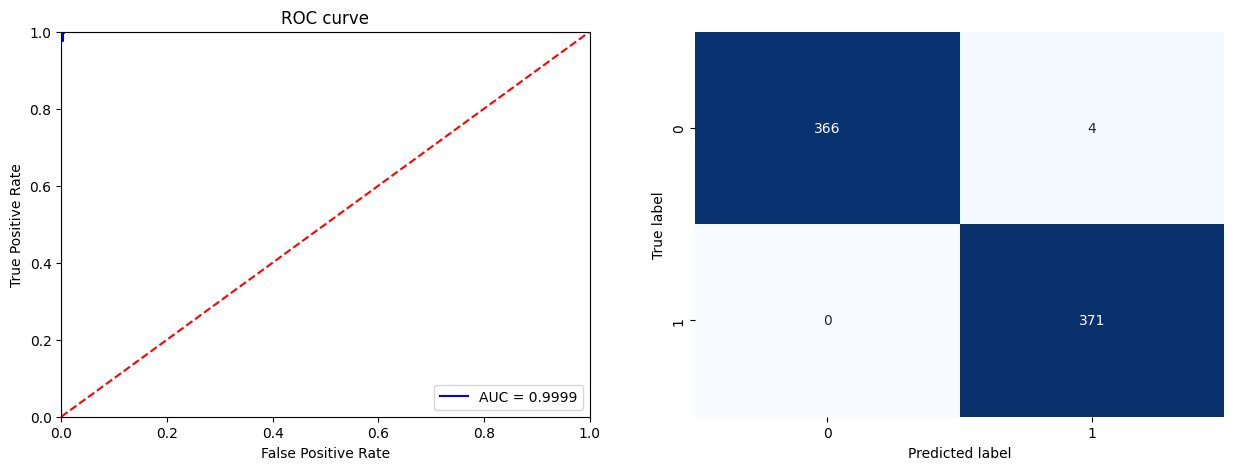

In [67]:
ROC_CM(all_folds_preds[3]['probs'], all_folds_preds[3]['true_labels'])

In [65]:
# Saving prediction and probs to CSV for testing dataset (better fold)

sub=pd.DataFrame()
sub['id'] = data.iloc[test_idx]['ID']
sub['probs'] = all_folds_preds[better_fold_index]['probs'][:, 1]  #np.mean(probs,0)
sub['prediction'] = sub['probs'].apply(lambda x: 1 if x>0.5 else 0)
sub['label'] = data.iloc[test_idx]['LABEL']
sub.to_csv(path + '/HitBert_' + str(n_fold) + 'kfold_predictions.csv', index=False)

In [53]:
# Saving testing metrics to CSV for each fold
pd.set_option('display.precision', 4)
df_stats = pd.DataFrame(data=all_folds_metrics)
df_stats = df_stats.set_index('fold')
df_stats.to_csv(path + '/HitBert_' + str(n_fold) + 'kfold_testing_stats_.csv')